# <center> Lecture14 : Hierarchical Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

In [3]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
# df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')


df_raw[df_raw[["stress","scontrol"]].isna().any(axis=1)]

,age,anxiety,anxiety_r,artgluctot,attachhome,attachphone,AvgHumidity,avgtemp,avoidance,avoidance_r,...,romantic,scontrol,sex,Site,smoke,socialdiversity,socialembedded,socTherm,soliTherm,stress


In [63]:
df_raw["Site"].unique()

array(['Bamberg', 'Chile', 'Kassel', 'METU', 'Oslo', 'Oxford', 'Poland',
       'Portugal', 'Serbia', 'SMU', 'Southampton', 'Tsinghua', 'UCSB',
       'VCU', 'Zurich'], dtype=object)

In [5]:
first5_site = ['Southampton','Portugal','Kassel','Tsinghua','UCSB']
df_first5 = df_raw.query("Site in @first5_site")

In [6]:
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]

df_first5["obs_id"] = range(len(df_first5))

df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)

df_first5["Site"].unique()

array(['Kassel', 'Portugal', 'Southampton', 'Tsinghua', 'UCSB'],
      dtype=object)

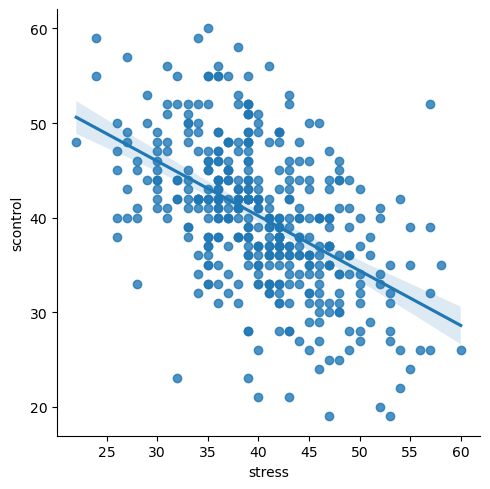

In [7]:
sns.lmplot(data=df_first5,
           x="stress",
           y="scontrol")

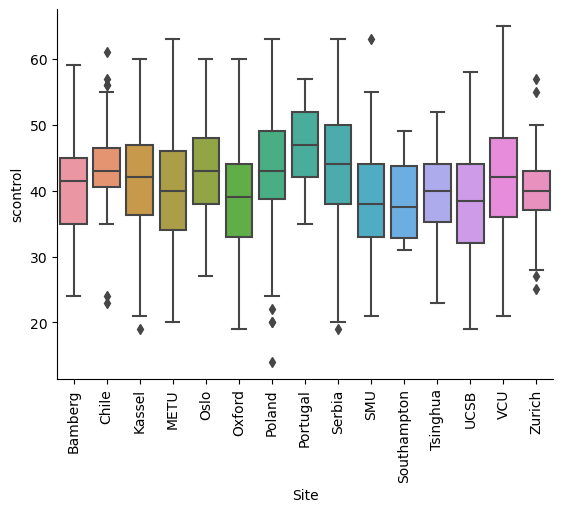

In [41]:
sns.boxplot(data=df_raw,
            x="Site",
            y="scontrol")

plt.xticks(rotation=90) 
sns.despine()
plt.show()


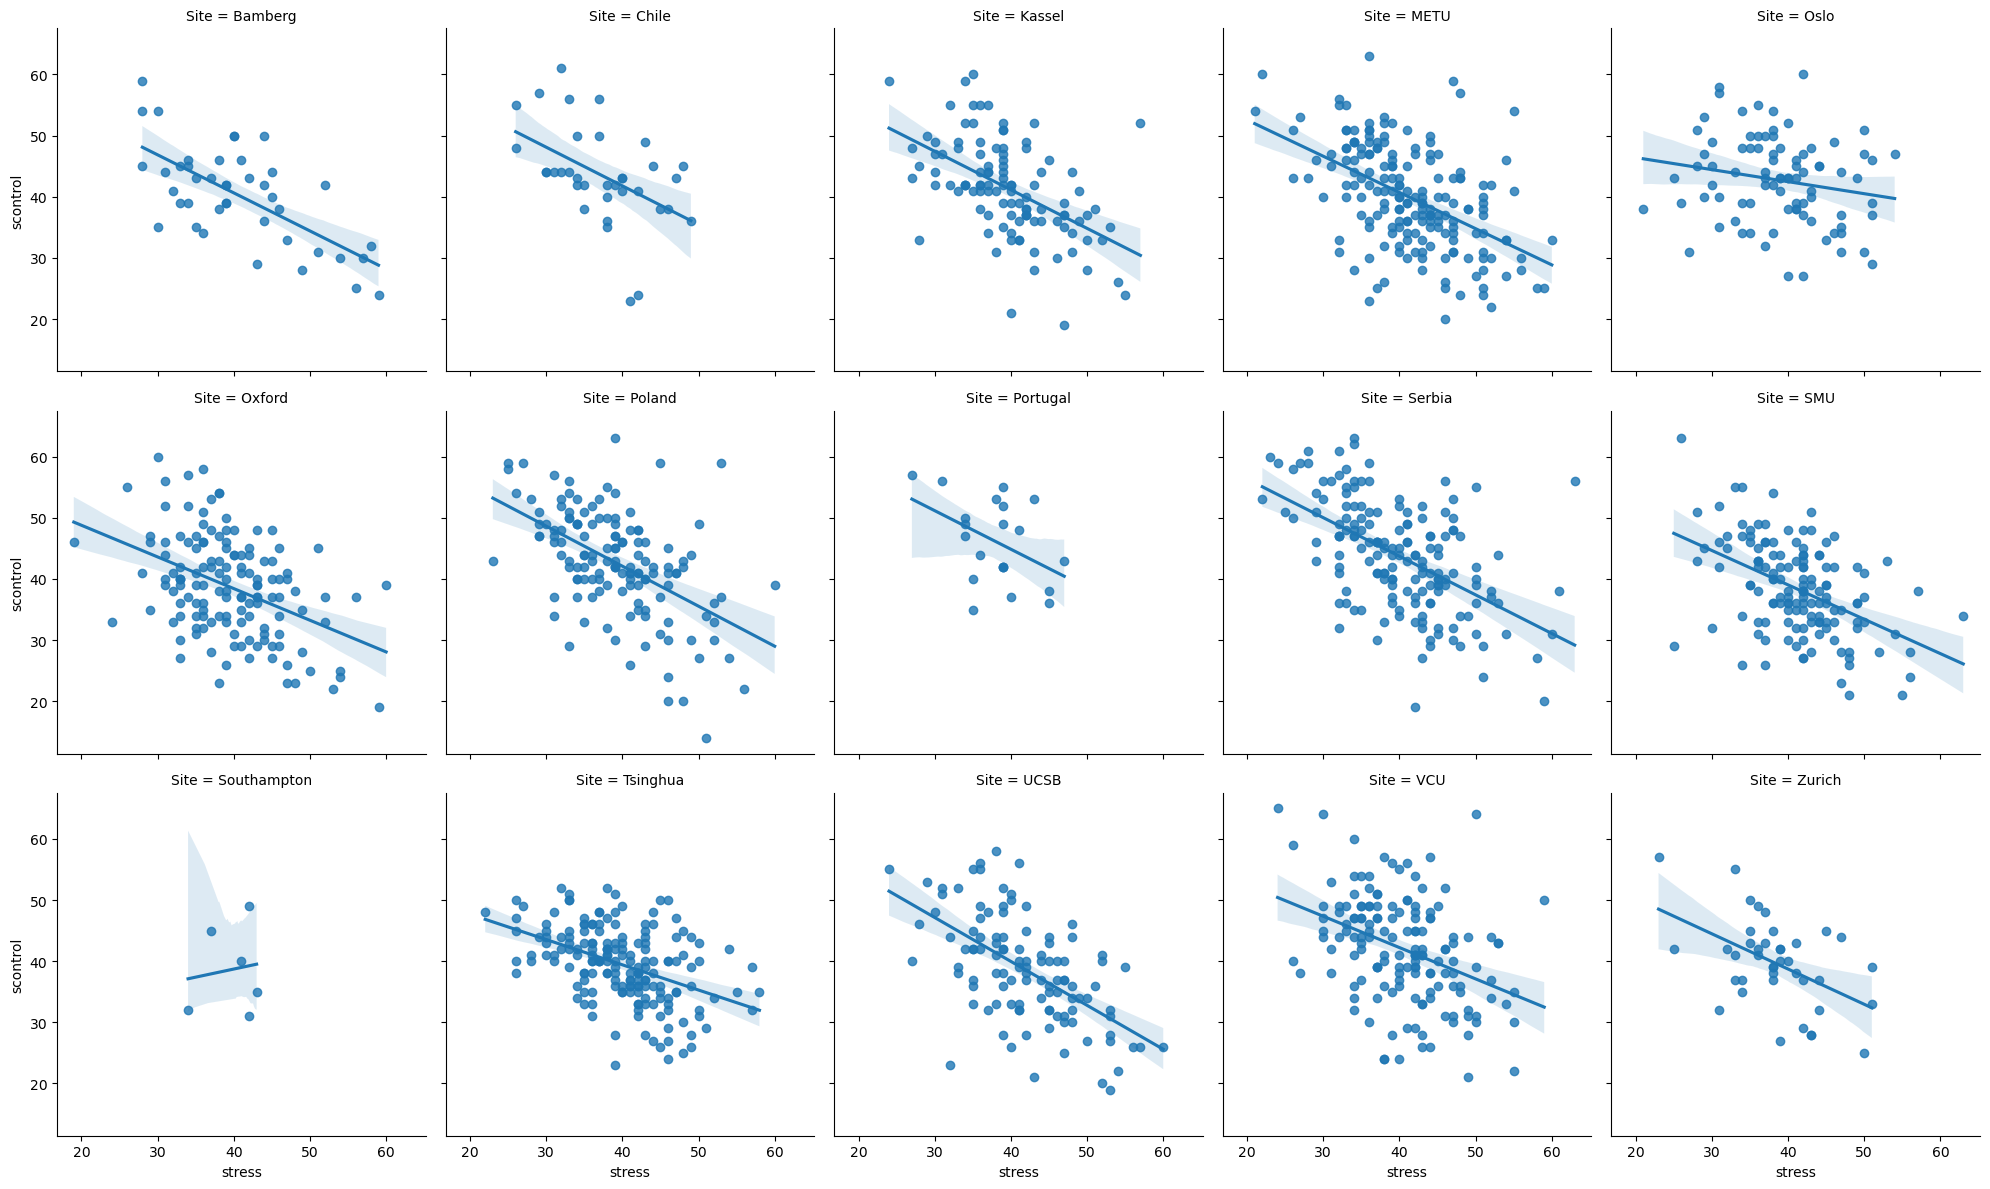

In [43]:
g = sns.FacetGrid(df_raw, col="Site", col_wrap=5, height=4)

# Map lmplot onto the grid
g.map(sns.regplot, "stress", "scontrol")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Complete pooling

$$  
\begin{equation}  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\  

\text{priors:} & & \beta_{0}  & \sim N\left(70, 4^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  
\end{equation}  
$$ 

In [ ]:
with pm.Model() as complete_pooled_model:

    beta_0 = pm.Normal("beta_0", mu=70, sigma=4)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    x = pm.MutableData("x",df_first5.stress)              #x是自变量压力水平

    mu = beta_0 + beta_1 * x                              #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol)   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                       #通过 observed 传入实际数据y 自我控制水平

## No pooling

$$

\begin{array}{rll}
Y_{ij} | \mu_{j}, \sigma_y & \sim N(\mu_{j}, \sigma_y^2) & \text{model of self control WITHIN Site $j$} \\
\mu_{j} | \mu, \sigma_\mu & \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) & \text{model of how typical running times vary BETWEEN runners} \\
\mu, \sigma_y, \sigma_\mu   & \sim \; ... & \text{prior models on global parameters} \\
\end{array}

$$

In [ ]:
with pm.Model() as complete_pooled_model:

    beta_0 = pm.Normal("beta_0", mu=70, sigma=4)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    x = pm.MutableData("x",df_first5.stress)              #x是自变量压力水平

    mu = beta_0 + beta_1 * x                              #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol)   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                       #通过 observed 传入实际数据y 自我控制水平

In [83]:
df_first5

age   anxiety  anxiety_r  artgluctot  attachhome  \
Site   obs_id                                                        
Kassel 0       1955.0  3.500000   0.323789         0.0    3.222222   
       1       1959.0  1.500000  -1.380456         0.0    4.444444   
       2       1965.0  1.333333  -1.522476         0.0    3.666667   
       3       1966.0  3.222222   0.087088         0.0    4.333333   
       4       1969.0  3.444444   0.276448         0.0    3.555556   
...               ...       ...        ...         ...         ...   
UCSB   410        NaN  4.611111   0.955335         1.0    4.666667   
       411        NaN  4.555556   0.910241         0.0    4.333333   
       412        NaN  5.166667   1.406280         0.0    3.555556   
       413        NaN  4.388889   0.774957         0.0    4.666667   
       414        NaN  1.166667  -1.840523         0.0    3.777778   

               attachphone  AvgHumidity    avgtemp  avoidance  avoidance_r  \
Site   obs_id                                                                
Kassel 0          3.666667         89.0  36.300000   3.777778     1.061474   
       1          2.111111          NaN  36.600000   2.722222    -0.124879   
       2          2.000000          NaN  35.450000   2.611111    -0.249759   
       3          1.000000          NaN  36.630000   3.166667     0.374638   
       4          1.444444         69.0  36.465000   3.222222     0.437077   
...                    ...          ...        ...        ...          ...   
UCSB   410        5.000000         51.0  36.494444   2.055556    -1.083724   
       411        2.888889         86.0  36.611111   5.000000     1.633418   
       412        2.666667         76.0  36.805556   5.000000     1.633418   
       413        3.111111         87.0  36.805556   4.666667     1.325817   
       414        2.777778         71.0  36.944444   2.944444    -0.263455   

               ...  sex    Site  smoke  socialdiversity  socialembedded  \
Site   obs_id  ...                                                        
Kassel 0       ...  1.0  Kassel    2.0                6               3   
       1       ...  2.0  Kassel    2.0                7               4   
       2       ...  1.0  Kassel    2.0                5               2   
       3       ...  2.0  Kassel    2.0                9               2   
       4       ...  2.0  Kassel    2.0               11               3   
...            ...  ...     ...    ...              ...             ...   
UCSB   410     ...  2.0    UCSB    2.0                6               4   
       411     ...  2.0    UCSB    2.0                9               2   
       412     ...  1.0    UCSB    2.0                6               6   
       413     ...  2.0    UCSB    1.0                9               7   
       414     ...  2.0    UCSB    2.0                9               6   

               socTherm  soliTherm  stress  site_idx  obs_id  
Site   obs_id                                                 
Kassel 0            3.0      3.125      30         0       0  
       1            2.4      3.125      30         0       1  
       2            3.8      2.375      31         0       2  
       3            3.6      2.875      47         0       3  
       4            2.2      2.750      50         0       4  
...                 ...        ...     ...       ...     ...  
UCSB   410          3.8      3.125      48         4     410  
       411          3.8      3.125      45         4     411  
       412          2.2      3.250      27         4     412  
       413          2.6      3.625      46         4     413  
       414          2.8      3.375      30         4     414  

[415 rows x 39 columns]

In [8]:
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    beta_0 = pm.Normal("beta_0", mu=70, sigma=4, dims="site")          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8, dims="site")         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6, dims="site")                  #定义sigma

    # Data
    x = pm.MutableData("x",df_first5.stress, dims="obs_id")
    g = pm.MutableData("g", df_first5.site_idx, dims="obs_id")
    # Linear model
    mu = pm.Deterministic("mu", beta_0[g] + beta_1[g] * x, dims="obs_id")
    # Define likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma[g], observed=df_first5.scontrol, dims="obs_id")

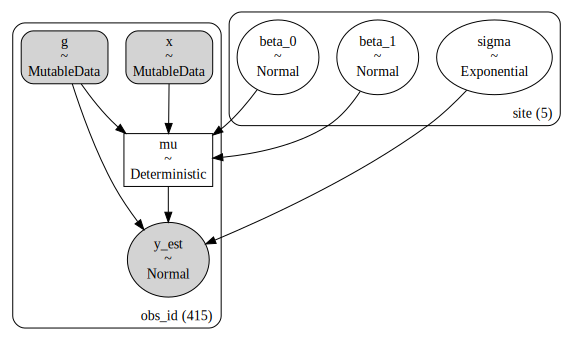

In [9]:
pm.model_to_graphviz(no_pooled_model)

In [39]:
nopool_prior = pm.sample_prior_predictive(samples=50,
                                          model=no_pooled_model,
                                          random_seed=84735)

Sampling: [beta_0, beta_1, sigma, y_est]


In [35]:
nopool_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [36]:
nopool_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [107]:
for i, group in enumerate(nopool_prior.constant_data["g"].values):
    print(i,group)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 1
121 1
122 1
123 1
124 1
125 1
126 1
127 2
128 2
129 2
130 2
131 2
132 2
133 3
134 3
135 3
136 3
137 3
138 3
139 3
140 3
141 3
142 3
143 3
144 3
145 3
146 3
147 3
148 3
149 3
150 3
151 3
152 3
153 3
154 3
155 3
156 3
157 3
158 3
159 3
160 3
161 3
162 3
163 3
164 3
165 3
166 3
167 3
168 3
169 3
170 3
171 3
172 3
173 3
174 3
175 3
176 3
177 3
178 3
179 3
180 3
181 3
182 3
183 3
184 3


In [26]:
nopool_prior.prior_predictive["y_est"].stack(sample=("chain","draw"))[:,0].values

array([ 4.15340783e+01,  4.13015932e+01,  4.10931420e+01,  2.95409217e+01,
        2.73873888e+01,  3.33829635e+01,  3.63967767e+01,  3.94260075e+01,
        3.28562364e+01,  3.45834469e+01,  2.51643971e+01,  3.86890490e+01,
        3.47532456e+01,  3.41895889e+01,  3.92200523e+01,  3.29826884e+01,
        2.77011805e+01,  2.21580690e+01,  3.12205848e+01,  3.53171754e+01,
        3.52664784e+01,  3.37078019e+01,  3.30963883e+01,  4.17242005e+01,
        3.47977807e+01,  3.50684668e+01,  3.24270200e+01,  3.85982690e+01,
        4.38197897e+01,  3.01364922e+01,  3.21507624e+01,  3.58290251e+01,
        4.25875056e+01,  4.32702876e+01,  3.27947799e+01,  3.59830918e+01,
        3.44099604e+01,  4.38021992e+01,  2.73546257e+01,  4.33085272e+01,
        3.65977886e+01,  3.99233358e+01,  3.87594524e+01,  3.32513308e+01,
        3.69996333e+01,  3.75449807e+01,  3.44627845e+01,  3.71951944e+01,
        2.56739600e+01,  3.01930451e+01,  3.80871323e+01,  2.85600371e+01,
        2.86211538e+01,  

In [41]:
nopool_prior.prior["mu"].stack(sample=("chain","draw"))

<xarray.DataArray 'mu' (obs_id: 415, sample: 50)>
array([[ 41.63884688, 103.42046367,  91.95122918, ...,  56.39276424,
         79.77155452,  25.02466071],
       [ 41.63884688, 103.42046367,  91.95122918, ...,  56.39276424,
         79.77155452,  25.02466071],
       [ 40.91859453, 104.49330973,  92.50172108, ...,  55.54275589,
         80.11260802,  23.48053813],
       ...,
       [ 96.02345383, 107.70537592,  64.03555489, ...,  58.72894432,
         71.34038236,  16.30982314],
       [116.61116097, 134.36564132,  57.03981304, ...,  51.44733807,
         75.76950475, -18.31350481],
       [ 99.27414443, 111.91489151,  62.93096407, ...,  57.57921701,
         72.03971748,  10.84298189]])
Coordinates:
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 7 ... 407 408 409 410 411 412 413 414
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int32 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

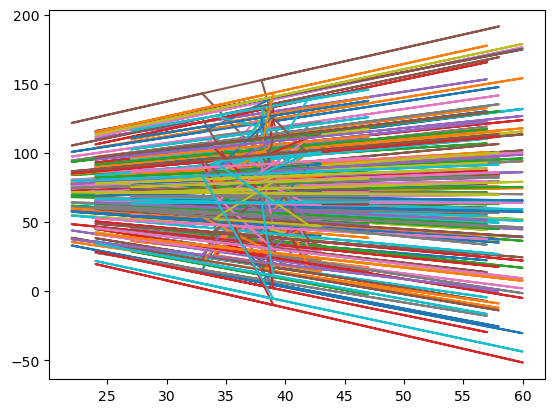

In [40]:
plt.plot(nopool_prior.constant_data["x"],
         nopool_prior.prior["mu"].stack(sample=("chain","draw")))

plt.show()

## Partial pooling